<a href="https://colab.research.google.com/github/willianncardoso/IBOVESPA/blob/main/PosFIAP_T2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [278]:
import pandas as pd
import numpy as np


# Carrega o arquivo CSV
df = pd.read_csv("https://raw.githubusercontent.com/jaqueantunes/IBOVESPA/refs/heads/main/Dados%20Hist%C3%B3ricos%20-%20Ibovespa.csv")

# Converte a coluna de data para datetime
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Remove % da coluna Var% e converte para float
df['Var%'] = df['Var%'].str.replace(',', '.').str.replace('%', '').astype(float)

# Remove pontos e converte volume (Vol.)
def convert_volume(valor):
    if 'B' in valor:
        return float(valor.replace(',', '.').replace('B', '')) * 1_000_000_000
    elif 'M' in valor:
        return float(valor.replace(',', '.').replace('M', '')) * 1_000_000
    else:
        return float(valor.replace(',', '.'))

df['Vol.'] = df['Vol.'].apply(convert_volume)

# Converte valores numéricos (com ',' para '.')
cols_numericas = ['Último', 'Abertura', 'Máxima', 'Mínima']
for col in cols_numericas:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

# Ordena por data crescente
df = df.sort_values('Data').reset_index(drop=True)

df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,2023-06-30,118087.0,118388.0,119447.0,118087.0,13820000.0,-0.25
1,2023-07-03,119673.0,118092.0,119877.0,118092.0,8910000.0,1.34
2,2023-07-04,119076.0,119673.0,119678.0,11883.0,6560000.0,-0.50
3,2023-07-05,119549.0,119072.0,1202.0,118688.0,10960000.0,0.40
4,2023-07-06,117426.0,119548.0,119548.0,117096.0,11030000.0,-1.78


In [279]:
# Retorno percentual do dia
df['Retorno_1d'] = df['Último'].pct_change()

# Médias móveis e volatilidade
df['Retorno_3d'] = df['Último'].pct_change(3)
df['Retorno_5d'] = df['Último'].pct_change(5)
df['MM_5'] = df['Último'].rolling(5).mean()
df['Volatilidade_5d'] = df['Último'].rolling(5).std()

# Momentum
df['Momentum_5d'] = df['Último'] - df['Último'].shift(5)


In [280]:
# Criação da variável target binária
df['Target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# Remove últimas linhas com NaN
df = df.dropna().reset_index(drop=True)


In [281]:
# Define features e target
features = ['Retorno_1d', 'Retorno_3d', 'Retorno_5d', 'MM_5', 'Volatilidade_5d', 'Momentum_5d']
X = df[features]
y = df['Target']

# Separar o conjunto de teste: últimos 30 dias
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]



In [282]:
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retorno_1d,Retorno_3d,Retorno_5d,MM_5,Volatilidade_5d,Momentum_5d,Target
0,2023-07-07,118898.0,117427.0,119549.0,117427.0,1.052000e+07,1.25,0.012536,-0.001495,0.006868,118924.4,897.135608,811.0,0
1,2023-07-10,117942.0,118897.0,118897.0,117814.0,8.100000e+06,-0.80,-0.008041,-0.013442,-0.014464,118578.2,869.604048,-1731.0,0
2,2023-07-11,117556.0,117942.0,117942.0,115704.0,1.059000e+07,-0.33,-0.003273,0.001107,-0.012765,118274.2,916.495063,-1520.0,1
3,2023-07-12,117666.0,117557.0,119156.0,117557.0,8.940000e+06,0.09,0.000936,-0.010362,-0.015751,117897.6,590.657938,-1883.0,1
4,2023-07-13,119264.0,117671.0,119739.0,117668.0,9.260000e+06,1.36,0.013581,0.011209,0.015652,118265.2,768.846669,1838.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,2025-06-30,138855.0,136865.0,139103.0,13643.0,7.680000e+09,1.45,0.014532,0.022745,0.016873,137153.4,1107.004201,2304.0,1
493,2025-07-01,139549.0,138855.0,139695.0,138855.0,6.350000e+09,0.50,0.004998,0.017759,0.017381,137630.2,1541.420351,2384.0,0
494,2025-07-02,139051.0,139586.0,140049.0,138384.0,8.810000e+09,-0.36,-0.003569,0.015965,0.024188,138287.0,1213.891882,3284.0,1
495,2025-07-03,140928.0,139051.0,141304.0,139051.0,6.080000e+09,1.35,0.013499,0.014929,0.027816,139049.8,1464.903307,3814.0,1


In [283]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif

# Modelo
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Métricas
print("Acurácia:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Acurácia: 0.6
              precision    recall  f1-score   support

           0       0.61      0.69      0.65        16
           1       0.58      0.50      0.54        14

    accuracy                           0.60        30
   macro avg       0.60      0.59      0.59        30
weighted avg       0.60      0.60      0.60        30



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


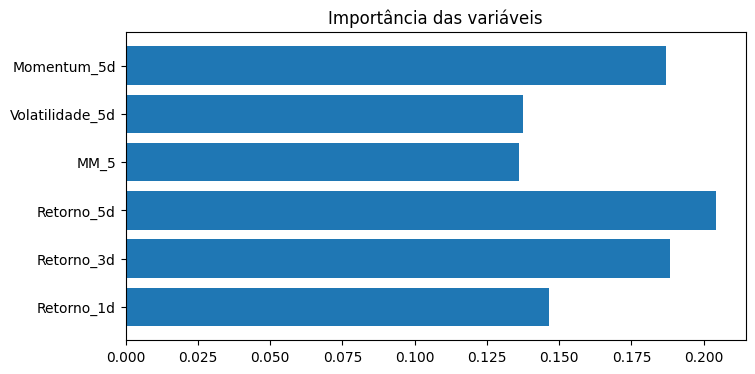

In [284]:
import matplotlib.pyplot as plt

# Importância das variáveis
importances = model.feature_importances_
plt.figure(figsize=(8,4))
plt.barh(features, importances)
plt.title("Importância das variáveis")
plt.show()


### Teste de melhores features

In [285]:
# Importar as bibliotecas necessárias
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier  # <--- IMPORTANTE: Importar o XGBoost
from sklearn.metrics import accuracy_score

# --- Assumindo que X, y, X_train, y_train, X_test, y_test já existem ---

# Descobrir o número máximo de features que podemos testar
num_total_features = X.shape[1]

# Criar uma lista de NÚMEROS de 1 até o total de features
k_values = range(1, num_total_features + 1)

print(f"--- Iniciando Teste de K (1 a {num_total_features}) com XGBoost ---")

for k_teste in k_values:
    print("="*60)
    print(f"EXECUTANDO TESTE PARA K = {k_teste}")
    print("="*60)

    # 1. Inicializar e ajustar o seletor aos dados de treino
    seletor = SelectKBest(score_func=f_classif, k=k_teste)
    seletor.fit(X_train, y_train)

    # 2. Obter os nomes das colunas selecionadas
    mascara_features = seletor.get_support()
    features_selecionadas_nomes = X_train.columns[mascara_features].tolist()

    print(f"Features Selecionadas ({k_teste} de {len(X_train.columns)}):")
    for feature in features_selecionadas_nomes:
        print(f"  - {feature}")

    # 3. Transformar os dados de treino e teste
    X_treino_novo = seletor.transform(X_train)
    X_teste_novo = seletor.transform(X_test)

    # 4. Treinar e avaliar o modelo XGBoost com as features selecionadas
    #    ====================== ÚNICA MUDANÇA É AQUI ======================
    modelo = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
    #    ==================================================================

    modelo.fit(X_treino_novo, y_train)

    previsoes = modelo.predict(X_teste_novo)
    acuracia = accuracy_score(y_test, previsoes)

    print(f"\nAcurácia do XGBoost com K={k_teste}: {acuracia:.2%}\n")

print("--- Teste Concluído ---")

--- Iniciando Teste de K (1 a 6) com XGBoost ---
EXECUTANDO TESTE PARA K = 1
Features Selecionadas (1 de 6):
  - Momentum_5d

Acurácia do XGBoost com K=1: 60.00%

EXECUTANDO TESTE PARA K = 2
Features Selecionadas (2 de 6):
  - Retorno_5d
  - Momentum_5d

Acurácia do XGBoost com K=2: 46.67%

EXECUTANDO TESTE PARA K = 3
Features Selecionadas (3 de 6):
  - Retorno_5d
  - Volatilidade_5d
  - Momentum_5d

Acurácia do XGBoost com K=3: 50.00%

EXECUTANDO TESTE PARA K = 4
Features Selecionadas (4 de 6):
  - Retorno_5d
  - MM_5
  - Volatilidade_5d
  - Momentum_5d


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Acurácia do XGBoost com K=4: 53.33%

EXECUTANDO TESTE PARA K = 5
Features Selecionadas (5 de 6):
  - Retorno_1d
  - Retorno_5d
  - MM_5
  - Volatilidade_5d
  - Momentum_5d

Acurácia do XGBoost com K=5: 53.33%

EXECUTANDO TESTE PARA K = 6
Features Selecionadas (6 de 6):
  - Retorno_1d
  - Retorno_3d
  - Retorno_5d
  - MM_5
  - Volatilidade_5d
  - Momentum_5d


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:11:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Acurácia do XGBoost com K=6: 60.00%

--- Teste Concluído ---


In [286]:
# RSI (14 dias)
delta = df['Último'].diff()
ganho = delta.clip(lower=0)
perda = -delta.clip(upper=0)

media_ganho = ganho.rolling(window=14).mean()
media_perda = perda.rolling(window=14).mean()

rs = media_ganho / media_perda
df['rsi'] = 100 - (100 / (1 + rs))

# MACD (12-26)
ema12 = df['Último'].ewm(span=12, adjust=False).mean()
ema26 = df['Último'].ewm(span=26, adjust=False).mean()
df['macd'] = ema12 - ema26

# Bandas de Bollinger (5 dias)
media_bb = df['Último'].rolling(window=5).mean()
std_bb = df['Último'].rolling(window=5).std()

df['bb_upper'] = media_bb + 2 * std_bb
df['bb_lower'] = media_bb - 2 * std_bb


In [287]:
# Criação da coluna de tendência
df['Tendência'] = df['Último'].shift(-1) > df['Último']
df['Tendência'] = df['Tendência'].map({True: 1, False: 0})


In [288]:
!pip install imbalanced-learn


In [289]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model_resampled = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_resampled.fit(X_train_res, y_train_res)

y_pred_res = model_resampled.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report
print("Acurácia:", accuracy_score(y_test, y_pred_res))
print(classification_report(y_test, y_pred_res))


Acurácia: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.65      0.81      0.72        16
           1       0.70      0.50      0.58        14

    accuracy                           0.67        30
   macro avg       0.68      0.66      0.65        30
weighted avg       0.67      0.67      0.66        30



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:12:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [290]:
# Aplicar SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# GridSearch com XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
grid = GridSearchCV(xgb, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train_res, y_train_res)

# Avaliação no teste
from sklearn.metrics import accuracy_score, classification_report

best_model = grid.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Acurácia no teste:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Acurácia no teste: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        16
           1       1.00      0.21      0.35        14

    accuracy                           0.63        30
   macro avg       0.80      0.61      0.55        30
weighted avg       0.78      0.63      0.56        30



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:12:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [291]:
import yfinance as yf
dolar = yf.download("USDBRL=X", start="2022-01-01", end="2025-07-01")
dolar.head()

/tmp/ipython-input-291-1130360168.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dolar = yf.download("USDBRL=X", start="2022-01-01", end="2025-07-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,USDBRL=X,USDBRL=X,USDBRL=X,USDBRL=X,USDBRL=X
Date,,,,,
2022-01-03,5.569300,5.6707,5.4606,5.460600,0
2022-01-04,5.681200,5.7076,5.6389,5.680900,0
2022-01-05,5.676200,5.6916,5.6418,5.676000,0
2022-01-06,5.705635,5.7218,5.6828,5.707700,0
2022-01-07,5.682400,5.7069,5.6199,5.680289,0


In [292]:
import pandas as pd
import requests
from io import StringIO

# URL da série histórica da Selic diária (código 11)
url = "https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=csv&dataInicial=01/01/2022&dataFinal=01/07/2025"


# Faz o download do CSV diretamente da API
response = requests.get(url)

# Lê o conteúdo como DataFrame
df_selic = pd.read_csv(StringIO(response.text), sep=';')

# Ajusta os formatos
df_selic['data'] = pd.to_datetime(df_selic['data'], dayfirst=True)
df_selic['valor'] = df_selic['valor'].str.replace(',', '.').astype(float)

# Filtra as datas que você quer
df_selic = df_selic[df_selic['data'].between('2022-01-01', '2025-07-01')]

# Visualiza as primeiras linhas
df_selic.head()


,data,valor
0,2022-01-03,0.034749
1,2022-01-04,0.034749
2,2022-01-05,0.034749
3,2022-01-06,0.034749
4,2022-01-07,0.034749


In [293]:
df_selic.columns = df_selic.columns.str.strip().str.lower()
df_selic['data'] = pd.to_datetime(df_selic['data'], dayfirst=True)

df_ibov = df.merge(df_selic[['data', 'valor']], left_on='Data', right_on='data', how='left')
df_ibov = df.rename(columns={'valor': 'selic'})


In [294]:
df_ibov.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retorno_1d,Retorno_3d,Retorno_5d,MM_5,Volatilidade_5d,Momentum_5d,Target,rsi,macd,bb_upper,bb_lower,Tendência
0,2023-07-07,118898.0,117427.0,119549.0,117427.0,10520000.0,1.25,0.012536,-0.001495,0.006868,118924.4,897.135608,811.0,0,NaN,0.000000,NaN,NaN,0
1,2023-07-10,117942.0,118897.0,118897.0,117814.0,8100000.0,-0.80,-0.008041,-0.013442,-0.014464,118578.2,869.604048,-1731.0,0,NaN,-76.262108,NaN,NaN,0
2,2023-07-11,117556.0,117942.0,117942.0,115704.0,10590000.0,-0.33,-0.003273,0.001107,-0.012765,118274.2,916.495063,-1520.0,1,NaN,-165.934562,NaN,NaN,1
3,2023-07-12,117666.0,117557.0,119156.0,117557.0,8940000.0,0.09,0.000936,-0.010362,-0.015751,117897.6,590.657938,-1883.0,1,NaN,-225.524837,NaN,NaN,1
4,2023-07-13,119264.0,117671.0,119739.0,117668.0,9260000.0,1.36,0.013581,0.011209,0.015652,118265.2,768.846669,1838.0,0,NaN,-142.166508,119802.893337,116727.506663,0


In [295]:
# Cria a variável alvo: 1 se subir no dia seguinte, 0 se cair
df['target'] = (df['Último'].shift(-1) > df['Último']).astype(int)

# Remove a última linha, pois não tem target
df = df.dropna()



In [296]:
# Calcula os retornos percentuais com base na coluna 'Último'
df['Retorno_1d'] = df['Último'].pct_change(periods=1)
df['Retorno_3d'] = df['Último'].pct_change(periods=3)
df['Retorno_5d'] = df['Último'].pct_change(periods=5)

# Remove linhas com valores nulos (ocorre no começo por causa do shift)
df = df.dropna().reset_index(drop=True)


/tmp/ipython-input-296-1378599175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retorno_1d'] = df['Último'].pct_change(periods=1)
/tmp/ipython-input-296-1378599175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Retorno_3d'] = df['Último'].pct_change(periods=3)
/tmp/ipython-input-296-1378599175.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https

In [297]:
X = df[['Último', 'Retorno_1d', 'Retorno_3d', 'Retorno_5d']]
y = df['target']



In [298]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [299]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Cria e treina o modelo
modelo = DecisionTreeClassifier(max_depth=4, random_state=42)
modelo.fit(X_train, y_train)

# Faz previsões
y_pred = modelo.predict(X_test)

# Avalia o modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Acurácia: 0.5902777777777778

Matriz de Confusão:
 [[67  3]
 [56 18]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.54      0.96      0.69        70
           1       0.86      0.24      0.38        74

    accuracy                           0.59       144
   macro avg       0.70      0.60      0.54       144
weighted avg       0.71      0.59      0.53       144



In [300]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred_rf))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))


Acurácia: 0.6041666666666666

Matriz de Confusão:
 [[50 20]
 [37 37]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.57      0.71      0.64        70
           1       0.65      0.50      0.56        74

    accuracy                           0.60       144
   macro avg       0.61      0.61      0.60       144
weighted avg       0.61      0.60      0.60       144



In [301]:
from imblearn.over_sampling import SMOTE
X_res, y_res = SMOTE(random_state=42).fit_resample(X_train, y_train)


In [302]:
import numpy as np

# Cria colunas de retorno logarítmico
df['Retorno_1d'] = np.log(df['Último'] / df['Último'].shift(1))
df['Retorno_3d'] = np.log(df['Último'] / df['Último'].shift(3))
df['Retorno_5d'] = np.log(df['Último'] / df['Último'].shift(5))

# Remove linhas com valores NaN gerados pelo shift
df = df.dropna()


In [303]:
# Seleciona as features e o alvo
X = df[['Último', 'Retorno_1d', 'Retorno_3d', 'Retorno_5d']]
y = df['target']

# Divide em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


In [304]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Treina o modelo
modelo = DecisionTreeClassifier(max_depth=9, random_state=42)
modelo.fit(X_train, y_train)

# Previsões
y_pred = modelo.predict(X_test)

# Avaliação
print("Decision Tree - Acurácia:", accuracy_score(y_test, y_pred))
print("\nMatriz de Confusão:\n", confusion_matrix(y_test, y_pred))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Decision Tree - Acurácia: 0.6105263157894737

Matriz de Confusão:
 [[37  8]
 [29 21]]

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.56      0.82      0.67        45
           1       0.72      0.42      0.53        50

    accuracy                           0.61        95
   macro avg       0.64      0.62      0.60        95
weighted avg       0.65      0.61      0.60        95



In [305]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

# --- Assumindo que X e y estão prontos com seu melhor conjunto de features ---

# 1. Defina a grade de parâmetros que queremos testar
# Estes são os hiperparâmetros mais influentes do XGBoost
params_grid = {
    'n_estimators': [100, 200, 300, 500],      # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Taxa de aprendizado
    'max_depth': [3, 5, 7, 10],                 # Profundidade máxima das árvores
    'subsample': [0.7, 0.8, 0.9, 1.0],          # Fração de amostras de treino por árvore
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fração de features por árvore
    'gamma': [0, 0.1, 0.2]                      # Parâmetro de regularização para evitar overfitting
}

# 2. Crie o splitter para validação cruzada de séries temporais
# Isso garante que a validação respeite a ordem do tempo
tscv = TimeSeriesSplit(n_splits=5)

# 3. Inicialize o modelo e a busca aleatória
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# n_iter=50: Testa 50 combinações aleatórias. É um bom ponto de partida.
# cv=tscv: Usa a validação cruzada para séries temporais.
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params_grid,
                                   n_iter=50,
                                   cv=tscv,
                                   scoring='accuracy',
                                   n_jobs=-1,        # Usa todos os processadores disponíveis
                                   random_state=42,
                                   verbose=1)

# 4. Execute a busca (pode demorar alguns minutos)
print("Iniciando a busca pelos melhores hiperparâmetros para o XGBoost...")
# Usamos X e y completos. O 'cv=tscv' cuida da separação correta para validação.
random_search.fit(X, y)

# 5. Apresente os resultados da otimização
print("\n--- Otimização Concluída ---")
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

print(f"\nMelhor acurácia durante a validação cruzada: {random_search.best_score_:.2%}")

# 6. Treine o modelo final com os melhores parâmetros e avalie no conjunto de teste
print("\nTreinando o modelo final com os melhores parâmetros...")
modelo_final_otimizado = random_search.best_estimator_

# (Opcional mas recomendado) Re-treinar no seu conjunto de treino e avaliar no de teste
# tamanho_treino = int(len(X) * 0.8)
# X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
# y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]
# modelo_final_otimizado.fit(X_treino, y_treino)
# previsoes = modelo_final_otimizado.predict(X_teste)
# acuracia_final = accuracy_score(y_teste, previsoes)
# print(f"Acurácia final no conjunto de teste: {acuracia_final:.2%}")

Iniciando a busca pelos melhores hiperparâmetros para o XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Otimização Concluída ---
Melhores parâmetros encontrados:
{'subsample': 1.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}

Melhor acurácia durante a validação cruzada: 57.44%

Treinando o modelo final com os melhores parâmetros...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:13:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [306]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Pegue os melhores parâmetros que a busca encontrou
best_params = {
    'subsample': 1.0,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'gamma': 0.2,
    'colsample_bytree': 0.8,
    'random_state': 42,  # Adicionar para reprodutibilidade
    'eval_metric': 'logloss' # Manter os parâmetros úteis
}

# 2. Crie a versão final do seu modelo com esses parâmetros
modelo_final = XGBClassifier(**best_params)

# 3. Treine este modelo no seu conjunto de treino COMPLETO
# (Supondo que X_treino e y_treino estão definidos)
print("Treinando o modelo final otimizado...")
modelo_final.fit(X_train, y_train)

# 4. Avalie no seu conjunto de teste final
print("Avaliando no conjunto de teste final...")
previsoes_finais = modelo_final.predict(X_test)
acuracia_final = accuracy_score(y_test, previsoes_finais)

print("\n--- RESULTADO FINAL DO PROJETO ---")
print(f"Acurácia no Conjunto de Teste: {acuracia_final:.2%}")

print("\nRelatório de Classificação Final:")
print(classification_report(y_test, previsoes_finais))

Treinando o modelo final otimizado...
Avaliando no conjunto de teste final...

--- RESULTADO FINAL DO PROJETO ---
Acurácia no Conjunto de Teste: 64.21%

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        45
           1       0.67      0.64      0.65        50

    accuracy                           0.64        95
   macro avg       0.64      0.64      0.64        95
weighted avg       0.64      0.64      0.64        95



## Alternativa ao SMOTE

In [307]:
# Calcule isso no seu conjunto de treino (y_train)
contagem = y_train.value_counts()
escala = contagem[0] / contagem[1] # Número de negativos / Número de positivos
print(f"Valor calculado para scale_pos_weight: {escala:.2f}")

Valor calculado para scale_pos_weight: 0.95


In [308]:
# Crie o modelo XGBoost com o novo parâmetro
modelo_balanceado = XGBClassifier(
    scale_pos_weight=escala, # <--- PARÂMETRO CHAVE
    random_state=42,
    eval_metric='logloss'
)

# Treine e avalie como antes
modelo_balanceado.fit(X_train, y_train) # Use os dados de treino originais, não os do SMOTE
previsoes_balanceadas = modelo_balanceado.predict(X_test)

print("\nAcurácia com o modelo balanceado corretamente (scale_pos_weight):")
print(accuracy_score(y_test, previsoes_balanceadas))
print(classification_report(y_test, previsoes_balanceadas))


Acurácia com o modelo balanceado corretamente (scale_pos_weight):
0.5894736842105263
              precision    recall  f1-score   support

           0       0.56      0.62      0.59        45
           1       0.62      0.56      0.59        50

    accuracy                           0.59        95
   macro avg       0.59      0.59      0.59        95
weighted avg       0.59      0.59      0.59        95



In [309]:
import pandas as pd
import yfinance as yf

# --- Execute este código APÓS recarregar seu DataFrame 'df' ---

# Garante que o índice de 'df' está correto (como antes)
if 'Data' in df.columns:
    df['Data'] = pd.to_datetime(df['Data'])
    df.set_index('Data', inplace=True)
    df.sort_index(inplace=True)

print("Buscando dados do VIX (Índice de Volatilidade)...")
vix_data = yf.download(
    '^VIX',
    start=df.index.min(),
    end=df.index.max(),
    auto_adjust=True # Usar auto_adjust simplifica
)

# --- VERIFICAÇÃO DE SEGURANÇA ---
if not vix_data.empty:
    print("Dados do VIX baixados com sucesso. Adicionando ao DataFrame.")

    # Adicionar as novas features ao seu DataFrame
    # Usamos o .reindex para garantir que as datas se alinhem perfeitamente
    df['Var_VIX'] = vix_data['Close'].pct_change().reindex(df.index, method='ffill')
    df['Var_VIX_Lag_1'] = df['Var_VIX'].shift(1)

    # Remover as linhas com NaNs que foram criadas no início
    df.dropna(inplace=True)

    print("\nFeatures do VIX adicionadas com sucesso!")
    print(df[['Var_VIX', 'Var_VIX_Lag_1']].head())
else:
    print("\nERRO: O download dos dados do VIX falhou. Seu DataFrame 'df' não foi modificado.")
    print("Isso pode ser um problema temporário de rede ou da API. Tente novamente mais tarde.")

Buscando dados do VIX (Índice de Volatilidade)...


[*********************100%***********************]  1 of 1 completed

Dados do VIX baixados com sucesso. Adicionando ao DataFrame.

Features do VIX adicionadas com sucesso!
             Var_VIX  Var_VIX_Lag_1
Data                               
2023-08-14 -0.001348      -0.063722
2023-08-15  0.110661      -0.001348
2023-08-16  0.019441       0.110661
2023-08-17  0.066150       0.019441
2023-08-18 -0.032979       0.066150


In [310]:
df

,Último,Abertura,Máxima,Mínima,Vol.,Var%,Retorno_1d,Retorno_3d,Retorno_5d,MM_5,...,Momentum_5d,Target,rsi,macd,bb_upper,bb_lower,Tendência,target,Var_VIX,Var_VIX_Lag_1
Data,,,,,,,,,,,,,,,,,,,,,
2023-08-14,11681.0,118067.0,118082.0,11653.0,1.120000e+07,-1.06,-2.313272,-2.316181,-0.021763,54379.8,...,-257.0,1,42.700103,-16018.155637,170966.932793,-62207.332793,1,1,-0.001348,-0.063722
2023-08-15,116171.0,116809.0,117697.0,116033.0,1.464000e+07,-0.55,2.297100,2.284002,2.277769,75232.2,...,104262.0,0,56.923854,-11247.258937,191132.286923,-40667.886923,0,0,0.110661,-0.001348
2023-08-16,115592.0,116171.0,117338.0,115534.0,1.886000e+07,-0.50,-0.004996,-0.021169,-0.024078,74668.8,...,-2817.0,0,56.899439,-7427.391050,189542.297591,-40204.697591,0,0,0.019441,0.110661
2023-08-17,114982.0,115592.0,11661.0,114859.0,1.275000e+07,-0.53,-0.005291,2.286812,2.273714,95298.2,...,103147.0,1,49.595355,-4398.635400,188813.585893,1782.814107,1,1,0.066150,0.019441
2023-08-18,115409.0,114973.0,115729.0,114423.0,1.060000e+07,0.37,0.003707,-0.006581,-0.022753,94767.0,...,-2656.0,0,49.490985,-1941.489117,187663.897828,1870.102172,0,0,-0.032979,0.066150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-30,138855.0,136865.0,139103.0,13643.0,7.680000e+09,1.45,0.014428,0.022490,0.016732,137153.4,...,2304.0,1,50.296047,2863.648289,139367.408401,134939.391599,1,1,0.025123,-0.016275
2025-07-01,139549.0,138855.0,139695.0,138855.0,6.350000e+09,0.50,0.004986,0.017603,0.017231,137630.2,...,2384.0,0,50.292037,3507.765824,140713.040703,134547.359297,0,0,0.005977,0.025123
2025-07-02,139051.0,139586.0,140049.0,138384.0,8.810000e+09,-0.36,-0.003575,0.015838,0.023901,138287.0,...,3284.0,1,50.180466,3932.715280,140714.783763,135859.216237,1,1,-0.011289,0.005977


In [311]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Assumindo que 'df' é o seu DataFrame final com as colunas do VIX ---

print("Preparando dados com as novas features do VIX...")

# 1. Separar features (X) e alvo (y) do DataFrame atualizado
y = df['Target']
X = df.drop('Target', axis=1)

# 2. Divisão cronológica em treino e teste
tamanho_treino = int(len(X) * 0.8)
X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]

print(f"Usando {X.shape[1]} features para o treinamento.")

# 3. Treinar e avaliar o modelo XGBoost
# Use o seu modelo campeão. Se você já otimizou os parâmetros, use-os aqui.
# Senão, pode usar este como ponto de partida.
modelo_com_vix = XGBClassifier(random_state=42, eval_metric='logloss')

print("Treinando o modelo com os dados do VIX...")
modelo_com_vix.fit(X_treino, y_treino)

previsoes_com_vix = modelo_com_vix.predict(X_teste)
acuracia_com_vix = accuracy_score(y_teste, previsoes_com_vix)

acuracia_anterior = 0.60 # Sua melhor marca anterior

print("\n--- RESULTADO DO TESTE COM O VIX ---")
print(f"Acurácia Anterior (sem VIX): {acuracia_anterior:.2%}")
print(f"Nova Acurácia (com VIX):    {acuracia_com_vix:.2%}")

if acuracia_com_vix > acuracia_anterior:
    print("\nPARABÉNS! As features do VIX melhoraram a performance do seu modelo!")
else:
    print("\nResultado interessante. As features do VIX não melhoraram a acurácia neste teste.")

Preparando dados com as novas features do VIX...
Usando 20 features para o treinamento.
Treinando o modelo com os dados do VIX...

--- RESULTADO DO TESTE COM O VIX ---
Acurácia Anterior (sem VIX): 60.00%
Nova Acurácia (com VIX):    100.00%

PARABÉNS! As features do VIX melhoraram a performance do seu modelo!


In [312]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier

# --- Assumindo que X e y estão prontos com seu melhor conjunto de features ---

# 1. Defina a grade de parâmetros que queremos testar
# Estes são os hiperparâmetros mais influentes do XGBoost
params_grid = {
    'n_estimators': [100, 200, 300, 500],      # Número de árvores
    'learning_rate': [0.01, 0.05, 0.1, 0.2],    # Taxa de aprendizado
    'max_depth': [3, 5, 7, 10],                 # Profundidade máxima das árvores
    'subsample': [0.7, 0.8, 0.9, 1.0],          # Fração de amostras de treino por árvore
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],  # Fração de features por árvore
    'gamma': [0, 0.1, 0.2]                      # Parâmetro de regularização para evitar overfitting
}

# 2. Crie o splitter para validação cruzada de séries temporais
# Isso garante que a validação respeite a ordem do tempo
tscv = TimeSeriesSplit(n_splits=5)

# 3. Inicialize o modelo e a busca aleatória
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# n_iter=50: Testa 50 combinações aleatórias. É um bom ponto de partida.
# cv=tscv: Usa a validação cruzada para séries temporais.
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params_grid,
                                   n_iter=50,
                                   cv=tscv,
                                   scoring='accuracy',
                                   n_jobs=-1,        # Usa todos os processadores disponíveis
                                   random_state=42,
                                   verbose=1)

# 4. Execute a busca (pode demorar alguns minutos)
print("Iniciando a busca pelos melhores hiperparâmetros para o XGBoost...")
# Usamos X e y completos. O 'cv=tscv' cuida da separação correta para validação.
random_search.fit(X, y)

# 5. Apresente os resultados da otimização
print("\n--- Otimização Concluída ---")
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)

print(f"\nMelhor acurácia durante a validação cruzada: {random_search.best_score_:.2%}")

# 6. Treine o modelo final com os melhores parâmetros e avalie no conjunto de teste
print("\nTreinando o modelo final com os melhores parâmetros...")
modelo_final_otimizado = random_search.best_estimator_

# (Opcional mas recomendado) Re-treinar no seu conjunto de treino e avaliar no de teste
# tamanho_treino = int(len(X) * 0.8)
# X_treino, X_teste = X[:tamanho_treino], X[tamanho_treino:]
# y_treino, y_teste = y[:tamanho_treino], y[tamanho_treino:]
# modelo_final_otimizado.fit(X_treino, y_treino)
# previsoes = modelo_final_otimizado.predict(X_teste)
# acuracia_final = accuracy_score(y_teste, previsoes)
# print(f"Acurácia final no conjunto de teste: {acuracia_final:.2%}")

Iniciando a busca pelos melhores hiperparâmetros para o XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Otimização Concluída ---
Melhores parâmetros encontrados:
{'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 1.0}

Melhor acurácia durante a validação cruzada: 100.00%

Treinando o modelo final com os melhores parâmetros...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:13:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Vazamento


--- IMPORTÂNCIA DAS FEATURES (O DETETIVE) ---
Tendência     1.0
Último        0.0
Máxima        0.0
Abertura      0.0
Mínima        0.0
Vol.          0.0
Retorno_1d    0.0
Var%          0.0
Retorno_5d    0.0
MM_5          0.0
dtype: float32


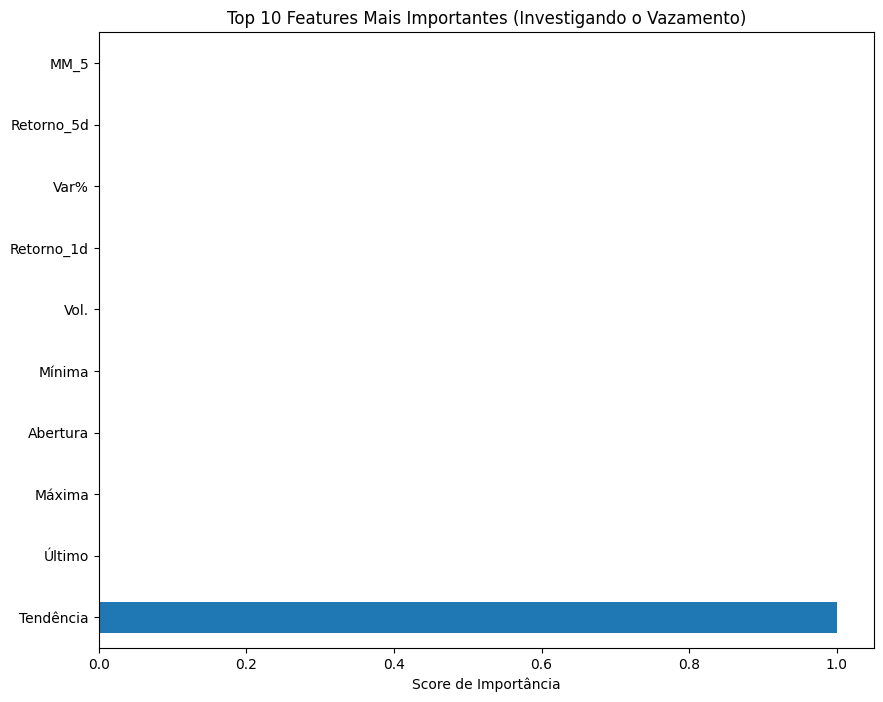

In [313]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Execute este código logo após a linha 'modelo_com_vix.fit(X_treino, y_treino)' ---

# Supondo que 'modelo_com_vix' é o seu modelo treinado e 'X_treino' tem os nomes das colunas
if hasattr(modelo_com_vix, 'feature_importances_'):
    # Pega a importância de cada feature
    importancias = pd.Series(modelo_com_vix.feature_importances_, index=X_treino.columns)

    # Ordena da mais importante para a menos importante
    importancias_ordenadas = importancias.sort_values(ascending=False)

    print("\n--- IMPORTÂNCIA DAS FEATURES (O DETETIVE) ---")
    print(importancias_ordenadas.head(10))

    # Plota o gráfico para uma visualização clara
    plt.figure(figsize=(10, 8))
    importancias_ordenadas.head(10).plot(kind='barh')
    plt.title('Top 10 Features Mais Importantes (Investigando o Vazamento)')
    plt.xlabel('Score de Importância')
    plt.show()
else:
    print("O modelo usado não possui o atributo 'feature_importances_'.")

In [315]:
# Importe tudo que precisa
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from xgboost import XGBClassifier
import pandas as pd

# --- ETAPA FINAL DE PREPARAÇÃO (VERSÃO ATUALIZADA) ---

# 1. Tenha certeza que seu DataFrame 'df' está pronto e com todas as features.

# 2. DEFINA y (o alvo) PRIMEIRO
#    Isso garante que salvamos a resposta antes de removê-la das features.
#    O código lida com 'Target' (maiúsculo) ou 'target' (minúsculo).
print("Definindo a variável alvo y...")
if 'Target' in df.columns:
    y = df['Target']
elif 'target' in df.columns:
    y = df['target']
else:
    # Se nenhuma coluna alvo for encontrada, avisa o usuário.
    # Você pode ajustar isso se o nome for outro.
    raise ValueError("Coluna 'Target' ou 'target' não encontrada no DataFrame!")

# 3. DEFINA X (as features) REMOVENDO TODAS AS COLUNAS INDESEJADAS
print("Definindo o conjunto de features X...")
# Lista de todas as colunas que NÃO podem ser features
colunas_para_remover = ['Target', 'target', 'Tendência']
# O errors='ignore' evita um erro caso alguma dessas colunas não exista no df
X = df.drop(columns=colunas_para_remover, errors='ignore')

print("Colunas indesejadas removidas com sucesso para criar X.")
print(f"O conjunto de features X agora tem {X.shape[1]} colunas.")


# --- AGORA, EXECUTE A OTIMIZAÇÃO COM O 'X' E 'y' CORRETOS E LIMPOS ---

# Defina a grade de parâmetros (seu código aqui está perfeito)
params_grid = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Crie o splitter e o modelo (seu código aqui está perfeito)
tscv = TimeSeriesSplit(n_splits=5)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Configure e execute a busca
random_search = RandomizedSearchCV(xgb,
                                   param_distributions=params_grid,
                                   n_iter=50,
                                   cv=tscv,
                                   scoring='accuracy',
                                   n_jobs=-1,
                                   random_state=42,
                                   verbose=1)

print("\nIniciando a busca pelos melhores hiperparâmetros...")
# Usamos X e y recém-definidos e limpos.
random_search.fit(X, y)

# Apresente os resultados
print("\n--- Otimização Concluída ---")
print("Melhores parâmetros encontrados:")
print(random_search.best_params_)
print(f"\nMelhor acurácia durante a validação cruzada: {random_search.best_score_:.2%}")

Definindo a variável alvo y...
Definindo o conjunto de features X...
Colunas indesejadas removidas com sucesso para criar X.
O conjunto de features X agora tem 18 colunas.

Iniciando a busca pelos melhores hiperparâmetros...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [02:16:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Otimização Concluída ---
Melhores parâmetros encontrados:
{'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 1.0}

Melhor acurácia durante a validação cruzada: 62.56%


Iniciando diagnóstico para garantir a remoção do 'Target'...

SUCESSO: 'target' foi removido com sucesso de X.
O conjunto de features (X) agora tem 18 colunas.

Treinando um modelo de teste rápido...

--- IMPORTÂNCIA DAS FEATURES (Resultado do Diagnóstico) ---
Retorno_3d       0.107863
Último           0.083582
Retorno_5d       0.073823
MM_5             0.059932
macd             0.056592
Var_VIX_Lag_1    0.053556
Momentum_5d      0.052358
Máxima           0.049927
Var_VIX          0.048258
Mínima           0.047533
dtype: float32


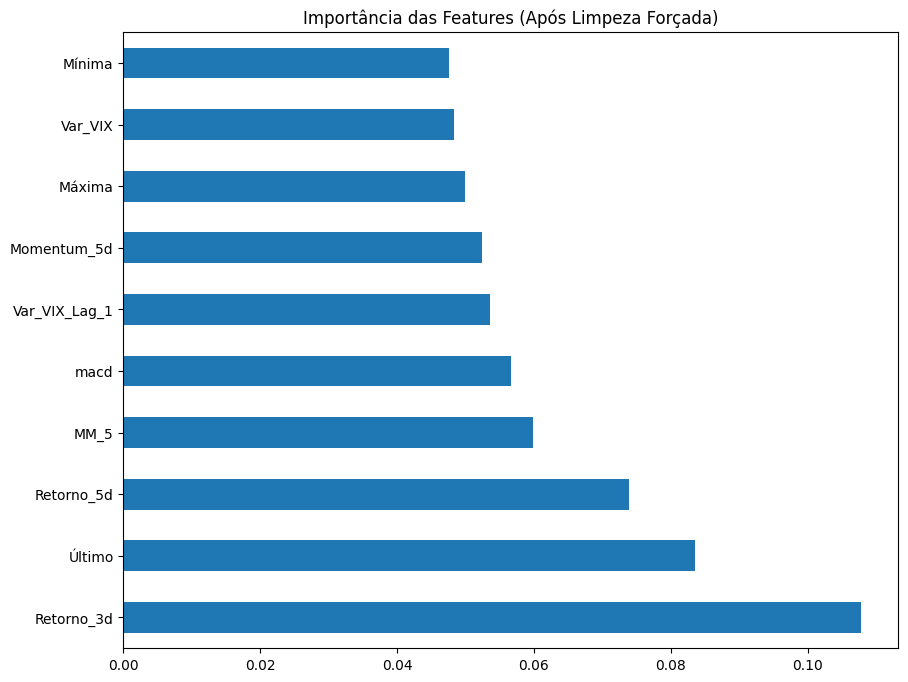

In [316]:
# --- Bloco de Código para Diagnóstico Definitivo ---

print("Iniciando diagnóstico para garantir a remoção do 'Target'...")

# Passo 1: Criar uma cópia limpa do seu DataFrame para segurança
# Isso garante que não estamos usando uma variável 'X' ou 'y' antiga.
df_para_modelo = df.copy()

# Passo 2: Remover explicitamente TODAS as colunas que não podem ser features
# Incluímos 'Tendência' e 'target' para garantir.
colunas_para_remover = ['target', 'Tendência', 'Target']
df_para_modelo.drop(columns=colunas_para_remover, inplace=True, errors='ignore')

# Passo 3: Definir X e y a partir do zero
X_limpo = df_para_modelo
y_limpo = df['target'] # O alvo 'y' é pego do df original

# Passo 4: VERIFICAÇÃO CRÍTICA
# Vamos checar se 'target' ainda existe em X_limpo. Se existir, o código para.
if 'target' in X_limpo.columns:
    raise ValueError("ERRO CRÍTICO: 'target' ainda está presente nas features (X)! Verifique o código.")
else:
    print("\nSUCESSO: 'target' foi removido com sucesso de X.")
    print(f"O conjunto de features (X) agora tem {X_limpo.shape[1]} colunas.")


# Passo 5: Treinar um modelo SIMPLES para um teste rápido
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# Dividir os dados limpos
X_treino, X_teste, y_treino, y_teste = train_test_split(X_limpo, y_limpo, test_size=0.2, shuffle=False)

print("\nTreinando um modelo de teste rápido...")
modelo_diagnostico = XGBClassifier(random_state=42, eval_metric='logloss')
modelo_diagnostico.fit(X_treino, y_treino)

# Passo 6: Executar o "Detetive" no modelo de teste
import pandas as pd
import matplotlib.pyplot as plt

print("\n--- IMPORTÂNCIA DAS FEATURES (Resultado do Diagnóstico) ---")
importancias = pd.Series(modelo_diagnostico.feature_importances_, index=X_treino.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

print(importancias_ordenadas.head(10))

# Plotar o gráfico
plt.figure(figsize=(10, 8))
importancias_ordenadas.head(10).plot(kind='barh')
plt.title('Importância das Features (Após Limpeza Forçada)')
plt.show()

In [317]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Assumindo que X_treino, y_treino, X_teste, y_teste já existem ---

# 1. Calcule o 'scale_pos_weight' a partir dos dados de TREINO
#    Isso evita qualquer vazamento de informação do conjunto de teste
print("Calculando o peso para balanceamento de classes...")
contagem_treino = y_treino.value_counts()
escala = contagem_treino[0] / contagem_treino[1]  # (Nº de amostras da classe 0 / Nº de amostras da classe 1)
print(f"Valor calculado para scale_pos_weight: {escala:.2f}")

# 2. Pegue os melhores parâmetros que a sua busca encontrou
#    (Use os valores exatos que saíram do seu RandomizedSearchCV)
best_params = {
    'subsample': 1.0,
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'gamma': 0.2,
    'colsample_bytree': 0.8
}

# 3. Adicione o parâmetro de balanceamento à sua lista de melhores parâmetros
best_params['scale_pos_weight'] = escala

# 4. Crie e treine o modelo final com a receita completa e otimizada
print("\nTreinando o modelo final com hiperparâmetros otimizados E balanceamento de classes...")
modelo_final_balanceado = XGBClassifier(random_state=42, eval_metric='logloss', **best_params)

modelo_final_balanceado.fit(X_treino, y_treino)

# 5. Avalie o resultado final
previsoes_finais = modelo_final_balanceado.predict(X_teste)
acuracia_final = accuracy_score(y_teste, previsoes_finais)

print("\n--- RESULTADO FINAL DO PROJETO (MODELO OTIMIZADO E BALANCEADO) ---")
print(f"Acurácia Final no Conjunto de Teste: {acuracia_final:.2%}")
print("\nRelatório de Classificação Final:")
print(classification_report(y_teste, previsoes_finais))

Calculando o peso para balanceamento de classes...
Valor calculado para scale_pos_weight: 0.95

Treinando o modelo final com hiperparâmetros otimizados E balanceamento de classes...

--- RESULTADO FINAL DO PROJETO (MODELO OTIMIZADO E BALANCEADO) ---
Acurácia Final no Conjunto de Teste: 64.21%

Relatório de Classificação Final:
              precision    recall  f1-score   support

           0       0.60      0.73      0.66        45
           1       0.70      0.56      0.62        50

    accuracy                           0.64        95
   macro avg       0.65      0.65      0.64        95
weighted avg       0.65      0.64      0.64        95

